In [1]:
"""
Notebook 3: Model Training dengan IndoBERT
Training model untuk deteksi cyberbullying
"""

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

from transformers import (
    BertTokenizer, 
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)

from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ===== SETUP =====
print("=== SETUP ===")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")



MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3                  # NAIK
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1          # BARU
EARLY_STOPPING_PATIENCE = 2



# ===== LOAD DATA =====
print("\n=== LOADING DATA ===")
train_df = pd.read_csv('../data/processed/train.csv')
val_df = pd.read_csv('../data/processed/val.csv')
test_df = pd.read_csv('../data/processed/test.csv')

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ===== DATASET CLASS =====
class CyberbullyingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

=== SETUP ===
Device: cpu

=== LOADING DATA ===
Train: 1476, Val: 316, Test: 317


In [2]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


In [3]:
# ===== LOAD TOKENIZER & MODEL =====
print("\n=== LOADING INDOBERT ===")
print("Mengunduh IndoBERT dari HuggingFace...")

# Menggunakan IndoBERT base model
MODEL_NAME = 'indobenchmark/indobert-base-p1'

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,  # Binary classification
    output_attentions=False,
    output_hidden_states=False
)

model = model.to(device)
print(f"✓ Model loaded: {MODEL_NAME}")


=== LOADING INDOBERT ===
Mengunduh IndoBERT dari HuggingFace...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded: indobenchmark/indobert-base-p1


In [4]:
# ===== CREATE DATALOADERS =====
print("\n=== CREATING DATALOADERS ===")

train_dataset = CyberbullyingDataset(
    texts=train_df['cleaned_comment'].values,
    labels=train_df['label'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = CyberbullyingDataset(
    texts=val_df['cleaned_comment'].values,
    labels=val_df['label'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# ===== OPTIMIZER & SCHEDULER =====
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)



=== CREATING DATALOADERS ===
Train batches: 93
Val batches: 20


In [5]:
# ===== TRAINING FUNCTIONS =====
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(data_loader, desc='Training')
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)
        
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    return correct_predictions.double() / total_predictions, np.mean(losses)

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_predictions += labels.size(0)
            
            losses.append(loss.item())
    
    return correct_predictions.double() / total_predictions, np.mean(losses)

In [6]:
# ===== TRAINING LOOP =====
print(f"\n=== TRAINING MODEL ({EPOCHS} EPOCHS) ===")
print("Note: Training mungkin memakan waktu beberapa menit...")

history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

best_val_acc = 0

for epoch in range(EPOCHS):
    print(f'\n--- Epoch {epoch + 1}/{EPOCHS} ---')
    
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    
    val_acc, val_loss = eval_model(model, val_loader, device)
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '../models/best_model.pt')
        print(f'✓ Model saved! (Val Acc: {val_acc:.4f})')

print("\n=== TRAINING SELESAI ===")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# ===== SAVE TRAINING HISTORY =====
history_df = pd.DataFrame(history)
history_df.to_csv('../results/metrics/training_history.csv', index=False)
print("✓ Training history disimpan")


=== TRAINING MODEL (3 EPOCHS) ===
Note: Training mungkin memakan waktu beberapa menit...

--- Epoch 1/3 ---


Training: 100%|██████████| 93/93 [31:19<00:00, 20.21s/it, loss=0.512]


Train Loss: 0.6207, Train Acc: 0.6409


Validation: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


Val Loss: 0.4959, Val Acc: 0.7468
✓ Model saved! (Val Acc: 0.7468)

--- Epoch 2/3 ---


Training: 100%|██████████| 93/93 [24:32<00:00, 15.84s/it, loss=0.604]


Train Loss: 0.3806, Train Acc: 0.8306


Validation: 100%|██████████| 20/20 [01:44<00:00,  5.20s/it]


Val Loss: 0.5267, Val Acc: 0.7563
✓ Model saved! (Val Acc: 0.7563)

--- Epoch 3/3 ---


Training: 100%|██████████| 93/93 [25:55<00:00, 16.72s/it, loss=0.499] 


Train Loss: 0.1910, Train Acc: 0.9282


Validation: 100%|██████████| 20/20 [01:45<00:00,  5.26s/it]

Val Loss: 0.6321, Val Acc: 0.7500

=== TRAINING SELESAI ===
Best Validation Accuracy: 0.7563
✓ Training history disimpan


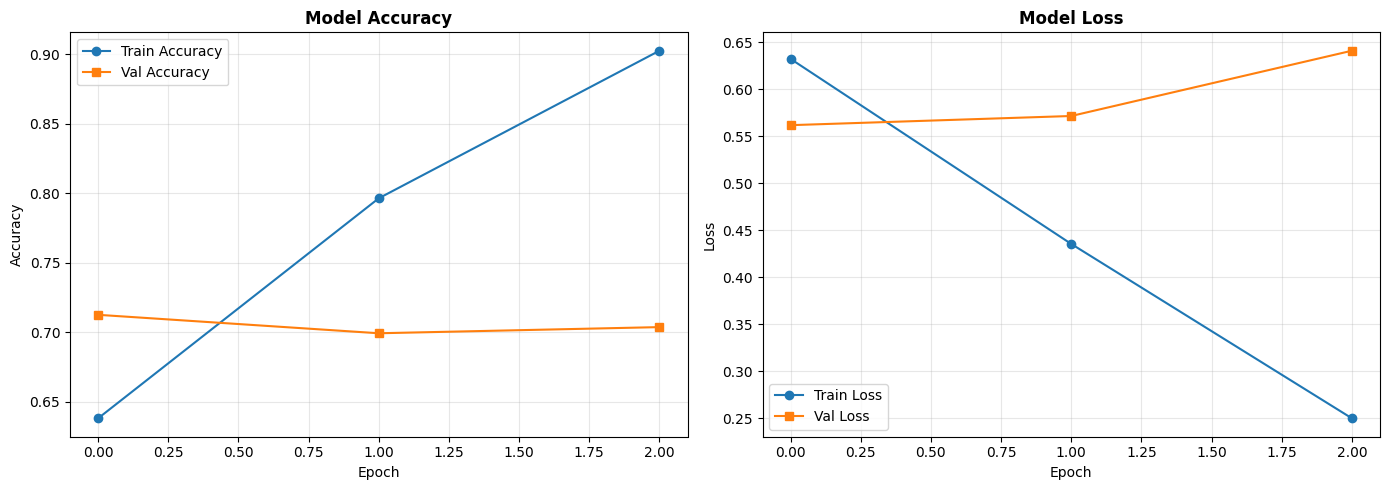


Lanjutkan ke notebook 04_evaluation_metrics.ipynb


In [7]:

# ===== PLOT TRAINING HISTORY =====
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[0].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history['train_loss'], label='Train Loss', marker='o')
axes[1].plot(history['val_loss'], label='Val Loss', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLanjutkan ke notebook 04_evaluation_metrics.ipynb")